In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animefacedataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F379764%2F737475%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240305%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240305T134405Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7fa3f49a2227bcab5933306eaaeed056ec9c867ecead0ce30da01168a22eb617e1e38061774df584567da2ce93cfef9cb8ccf0fdd79ca797ef9909888ab924cfbb98f98f1c5dd9a818c9f97a75fbec3e9f77fa508ea43a33a5d58e6c22d610226cb5a10d0335bcb345c319a255a6c6b27d978b6a31cfa424373f6ca503b2ea07c4f20aa54c2069c688479f4ee40456042e2b5e5d0a83d61a2320e43cd64f80f042beeb9a9170da0e5ad68a3ccc500ec28e13a449402129c43138531f5e5e99939ca0eb57545ee782e79f8d08407033d4b10e723718db7a4b80d1f00da231ebef94cebeb3a09c06856591f0224ab28f752720fb748fc13dbfb0ad6d0138517465'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 413825766 bytes downloaded
Downloaded and uncompressed: animefacedataset
Data source import complete.


In [2]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'  # or ':16:8

import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [9]:
# Root directory for dataset
root = '/kaggle/input/animefacedataset'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1



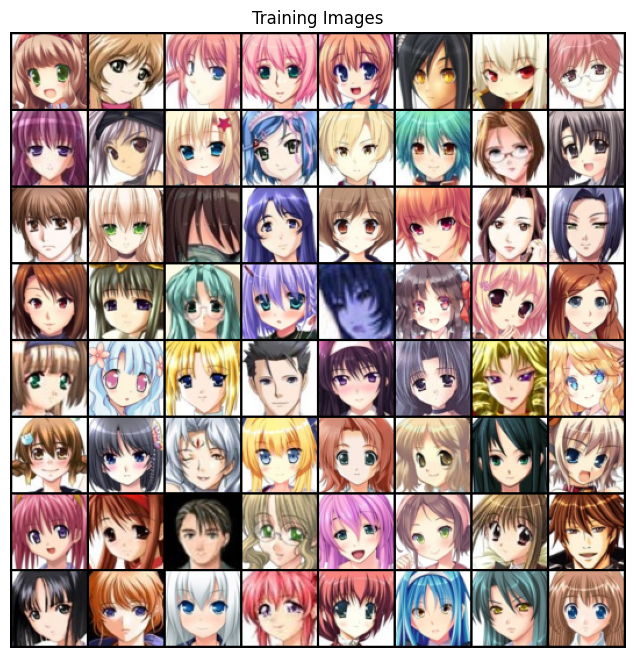

In [10]:
dataset = dset.ImageFolder(root = root, transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


train_size =  int(0.8 * len(dataset))
validation_size =  len(dataset) -  train_size

train_dataset, validation_dataset =  data.random_split(dataset, [train_size, validation_size])
train_loader =  data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
val_loader = data.DataLoader(validation_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [12]:
class self_attention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()

        self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim//8, kernel_size =  1)
        self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim//8, kernel_size =  1)
        self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels =  in_dim, kernel_size =  1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax =  nn.Softmax(dim = -1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query =  self.query_conv(x).view(batch_size, -1, width*height).permute(0,2,1)
        proj_key = self.key_conv(x).view(batch_size, -1, width*height)

        energy = torch.matmul(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width*height)

        out = torch.matmul(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        out = self.gamma * out + x

        return out

In [13]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``

            self_attention(ngf),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [14]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): self_attention(
      (query_conv): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (key_conv): Conv2d

In [15]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            self_attention(ndf * 8),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [16]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): self_attention(
      (query_conv): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
      (key_conv): Conv2d(512, 6

In [17]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [18]:
from tqdm.notebook import tqdm

img_list = []
train = {
    "G_losses" : [],
    "D_losses" : [],
    "D_xs": [],
    "D_G_z1s": [],
    "D_G_z2s" : []
}

val = {
    "G_losses" : [],
    "D_losses" : [],
    "D_xs" : [],
    "D_G_z1s" : [],
    "D_G_z2s" : []
}


iters = 0

num_epochs = 30

for epoch in tqdm(range(num_epochs)):

    ################
    ### Training ###
    ################

    for i, data in enumerate(train_loader, 0):
        optimizerD.zero_grad()
        real_data = data[0].to(device)
        b_size = real_data.size(0)


        #Generate Fake Image

        targets = torch.ones(batch_size, 1, device = device)
        noise = torch.randn(b_size, nz, 1, 1, device = device)
        fake_data = netG(noise)



        #Discriminator losses

        #Real loss

        output = netD(real_data).view(-1)
        real_targets =  torch.ones(real_data.size(0), 1, device = device)
        errD_Real =  criterion(output, real_targets.squeeze(1))
        errD_Real.backward()
        D_x = output.mean().item()

        #Fake Loss

        fake_targets = torch.zeros(fake_data.size(0), 1, device = device)
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, fake_targets.squeeze(1))

        errD_fake.backward()
        D_G_z1 = output.mean().item()


        #Discriminator loss

        err_D = (errD_Real + errD_fake)/2
        optimizerD.step()

        #Generator Loss function

        optimizerG.zero_grad()
        output = netD(fake_data).view(-1)
        Gfake_targets =  torch.ones_like(output)

        errG = criterion(output, Gfake_targets)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        #Save the Logs

        train["G_losses"].append(errG.item())
        train["D_losses"].append(err_D.item())
        train["D_xs"].append(D_x)
        train["D_G_z1s"].append(D_G_z1)
        train["D_G_z2s"].append(D_G_z2)

    with torch.no_grad():
        ##################
        ### Validation ###
        ##################

        for i, data in enumerate(val_loader, 0):
            real_data = data[0].to(device)
            b_size = real_data.size(0)

            targets = torch.ones(batch_size, 1, device=device)
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_data = netG(noise)

            output = netD(real_data).view(-1)
            real_targets = torch.ones(real_data.size(0), 1, device=device)
            errD_real = criterion(output, real_targets.squeeze(1))
            D_x = output.mean().item()

            fake_targets = torch.zeros(fake_data.size(0), 1, device=device)
            output = netD(fake_data.detach()).view(-1)
            errD_fake = criterion(output, fake_targets.squeeze(1))
            D_G_z1 = output.mean().item()

            errD = (errD_real + errD_fake)/2

            output = netD(fake_data).view(-1)
            Gfake_targets = torch.ones_like(output)

            errG = criterion(output, Gfake_targets)
            D_G_z2 = output.mean().item()

            val["G_losses"].append(errG.item())
            val["D_losses"].append(errD.item())
            val["D_xs"].append(D_x)
            val["D_G_z1s"].append(D_G_z1)
            val["D_G_z2s"].append(D_G_z2)

    print('Train Logs - [Epoch %d] : G_Loss : %.4f | D_Loss : %.4f | D(x) : %.4f | D(G(z)): %.4f/%.4f'%(epoch,train["G_losses"][epoch],
                                                                                           train["D_losses"][epoch],
                                                                                           train["D_xs"][epoch],
                                                                                           train["D_G_z1s"][epoch],
                                                                                           train["D_G_z2s"][epoch]))






  0%|          | 0/30 [00:00<?, ?it/s]

Train Logs - [Epoch 0] : G_Loss : 2.5447 | D_Loss : 0.9245 | D(x) : 0.3506 | D(G(z)): 0.3748/0.1061
Train Logs - [Epoch 1] : G_Loss : 4.2530 | D_Loss : 1.2484 | D(x) : 0.9979 | D(G(z)): 0.8768/0.0228
Train Logs - [Epoch 2] : G_Loss : 6.3614 | D_Loss : 0.4965 | D(x) : 0.9950 | D(G(z)): 0.5600/0.0028
Train Logs - [Epoch 3] : G_Loss : 6.5731 | D_Loss : 0.0966 | D(x) : 0.9814 | D(G(z)): 0.1491/0.0021
Train Logs - [Epoch 4] : G_Loss : 6.1076 | D_Loss : 0.1177 | D(x) : 0.9707 | D(G(z)): 0.1671/0.0034
Train Logs - [Epoch 5] : G_Loss : 7.1080 | D_Loss : 0.2148 | D(x) : 0.9512 | D(G(z)): 0.2753/0.0012
Train Logs - [Epoch 6] : G_Loss : 6.9635 | D_Loss : 0.1196 | D(x) : 0.9068 | D(G(z)): 0.0926/0.0016
Train Logs - [Epoch 7] : G_Loss : 6.8207 | D_Loss : 0.1083 | D(x) : 0.9415 | D(G(z)): 0.1244/0.0017
Train Logs - [Epoch 8] : G_Loss : 7.8551 | D_Loss : 0.1302 | D(x) : 0.9652 | D(G(z)): 0.1631/0.0006
Train Logs - [Epoch 9] : G_Loss : 7.5710 | D_Loss : 0.0958 | D(x) : 0.9393 | D(G(z)): 0.0882/0.0008


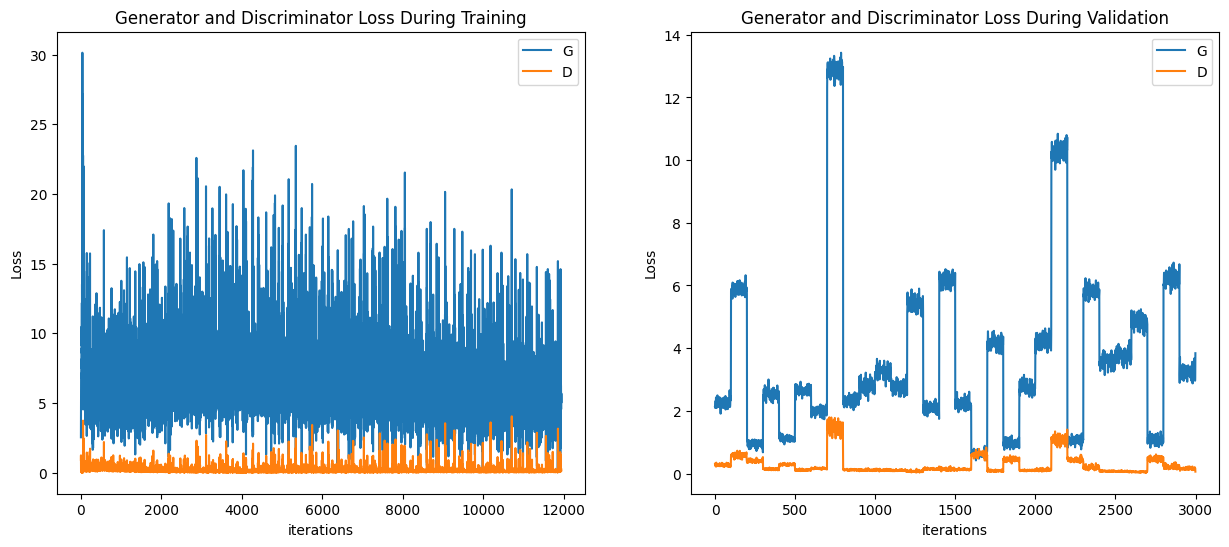

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title("Generator and Discriminator Loss During Training")
axes[0].plot(train["G_losses"],label="G")
axes[0].plot(train["D_losses"],label="D")
axes[0].set_xlabel("iterations")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].set_title("Generator and Discriminator Loss During Validation")
axes[1].plot(val["G_losses"],label="G")
axes[1].plot(val["D_losses"],label="D")
axes[1].set_xlabel("iterations")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.show()

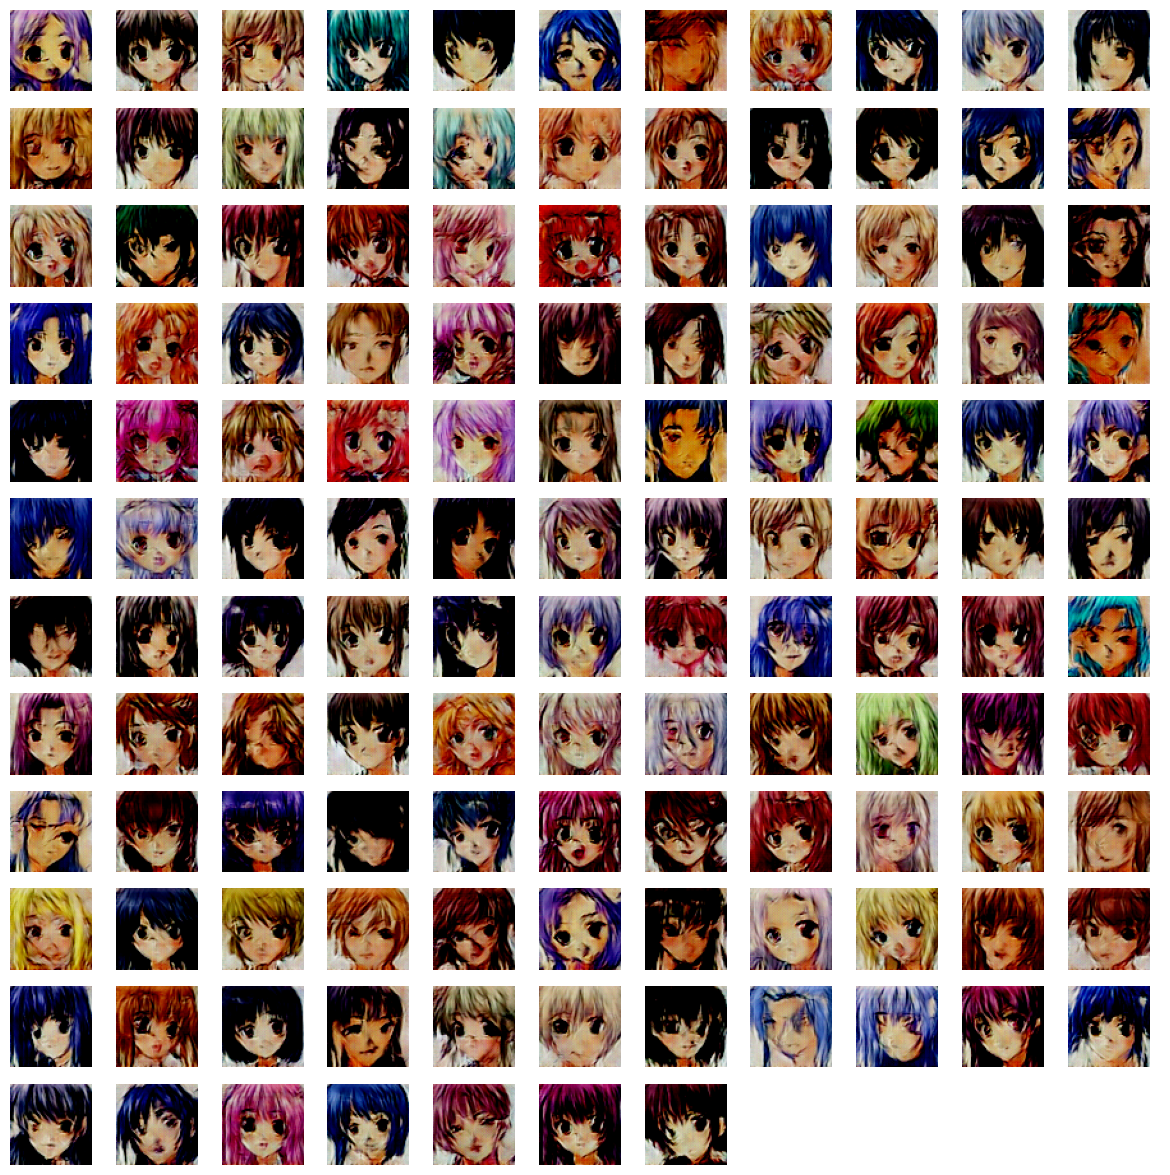

In [20]:
def generated_image_plot(fake_data, title="Generated Images Grid"):
    batch_size, channels, height, width = fake_data.shape

    num_rows = int(np.ceil(np.sqrt(batch_size)))
    num_cols = int(np.ceil(batch_size / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(batch_size):
        img = fake_data[i].cpu().detach().numpy()
        img = np.transpose(img, (1, 2, 0))
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(img)
        ax.axis("off")

    for i in range(batch_size, num_rows * num_cols):
        axes.flatten()[i].axis("off")

    plt.subplots_adjust(wspace=0.01)

    plt.show()
    batch_size, channels, height, width = fake_data.shape


fake_data = netG(fixed_noise)
generated_image_plot(fake_data)